<a href="https://colab.research.google.com/github/AnnapoorneswariMadhuChandraReddy/DS600/blob/main/DeepLearningAnnapoorneswari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Annapoorneswari Madhu Chandra Reddy
MSDS 686, Deep Learning Project


#Overview of assignment
This assignment involves building a deep learning model, specifically using the ResNet architecture, to classify chest X-ray images into two categories: "Normal" and "Pneumonia."
The goal is to use confusion matrices, accuracy metrics, and other performance indicators to evaluate the model's efficacy in diagnosing pneumonia from X-ray pictures. The project implements a convolutional neural network (CNN) for medical image categorization using a popular dataset from Kaggle.

#Data
For this project, I have used the chest x-rays. In this data, it containes of  5,863 X-Ray images with categories of COVID-19 X-Rays, Normal X-Rays, viral-pneumonia X-Rays, and bacterial-pneumonia X-Rays. This dataset serves as a baseline for assessing the effectiveness of different image recognition technologies in the healthcare industry in addition to being a rich source for creating diagnostic models.

There is the kaggle link for the data - https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! unzip /content/drive/MyDrive/pnuemonia.zip

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display, Image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from sklearn.preprocessing import label_binarize
from keras.preprocessing import image

In [ ]:
import csv
import os
from glob import glob
import shutil
from random import shuffle
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet152V2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

We have loaded are the required libraries and functions for the project.

In [ ]:
from sklearn.model_selection import train_test_split

base_dir =  '/content/chestraydata1/Curated X-Ray Dataset/Curated X-Ray Dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

categories = ['Normal', 'Pneumonia-Viral', 'Pneumonia-Bacterial']

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)


We have categories like normal, Pneumonia-Viral and Pneumonia-Bacterial. We are creating subdirectories in each of the train, test, and val directories for the categories.

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, VALIDATION, split_size):
    all_files = os.listdir(SOURCE)
    np.random.shuffle(all_files)

    train_size = int(len(all_files) * split_size[0])
    val_size = int(len(all_files) * split_size[1])

    train_files = all_files[:train_size]
    val_files = all_files[train_size:train_size + val_size]
    test_files = all_files[train_size + val_size:]

    for file_name in train_files:
        shutil.copy(os.path.join(SOURCE, file_name), os.path.join(TRAINING, file_name))

    for file_name in val_files:
        shutil.copy(os.path.join(SOURCE, file_name), os.path.join(VALIDATION, file_name))

    for file_name in test_files:
        shutil.copy(os.path.join(SOURCE, file_name), os.path.join(TESTING, file_name))

split_size = [0.7, 0.1]

for category in categories:
    source_dir = os.path.join(base_dir, category)

    split_data(
        SOURCE=source_dir,
        TRAINING=os.path.join(train_dir, category),
        TESTING=os.path.join(test_dir, category),
        VALIDATION=os.path.join(val_dir, category),
        split_size=split_size
    )


In [ ]:
# Verify the number of files in each category
for category in categories:
    print(f"Category: {category}")
    print(f"Train: {len(os.listdir(os.path.join(train_dir, category)))}")
    print(f"Val: {len(os.listdir(os.path.join(val_dir, category)))}")
    print(f"Test: {len(os.listdir(os.path.join(test_dir, category)))}\n")


Category: Normal
Train: 2289
Val: 327
Test: 655

Category: Pneumonia-Viral
Train: 1159
Val: 165
Test: 332

Category: Pneumonia-Bacterial
Train: 2100
Val: 300
Test: 601



We are verifying number of files in each category.

In [ ]:
import random
import matplotlib.image as mpimg

def display_random_images(train_dir, categories, num_images):
    all_images = []
    i = 0
    for category in categories:
        folder_path = os.path.join(train_dir, category)
        for image_name in os.listdir(folder_path):
            all_images.append((os.path.join(folder_path, image_name), category))
            i+=1
        if i == num_images:
          break
    selected_images = random.sample(all_images, num_images)

    for image_path, label in selected_images:
        img = mpimg.imread(image_path)
        plt.figure(figsize=(5, 5))
        plt.imshow(img, cmap='gray')
        plt.title(f'Label: {label}', fontsize=14)
        plt.axis('off')
        plt.show()




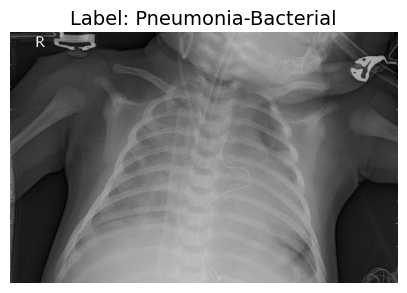

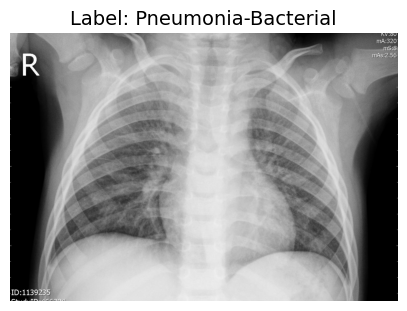

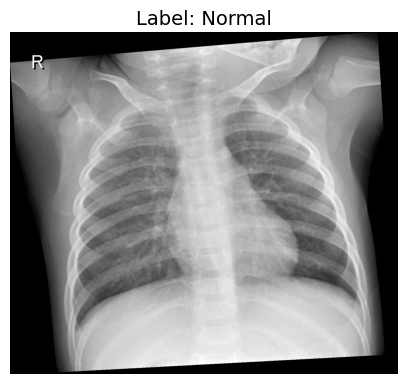

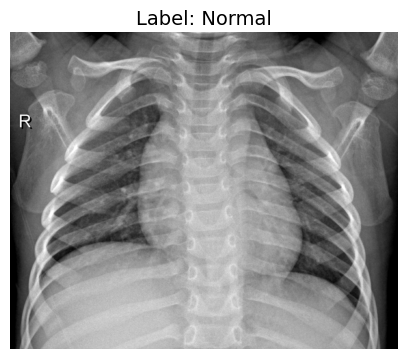

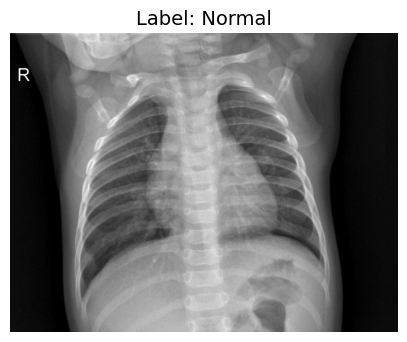

In [ ]:
display_random_images(train_dir, categories,5)

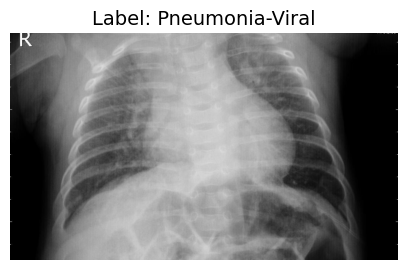

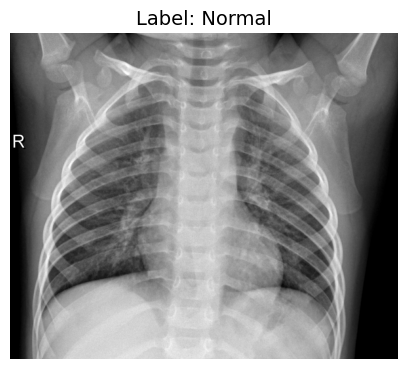

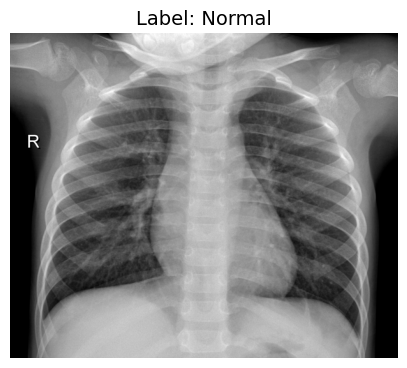

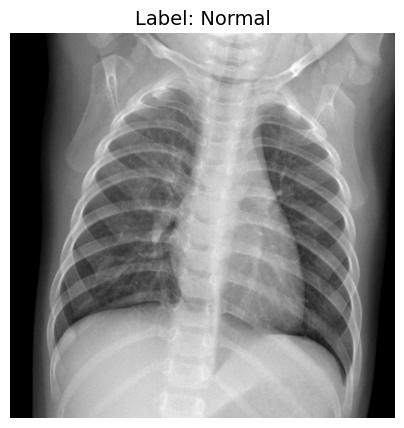

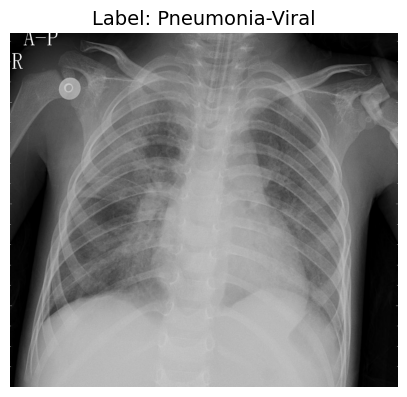

In [ ]:
display_random_images(val_dir, categories,5)

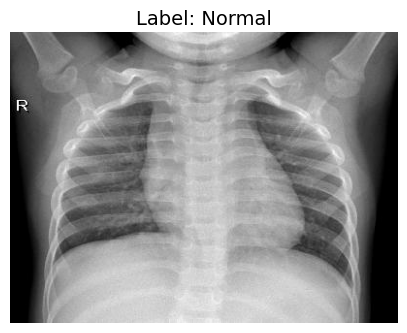

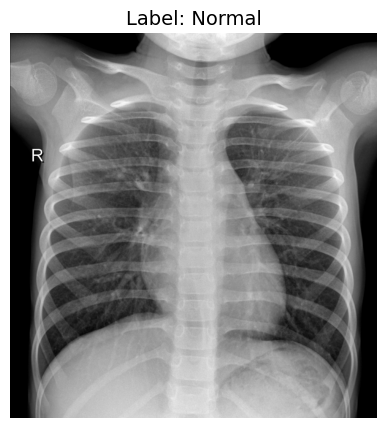

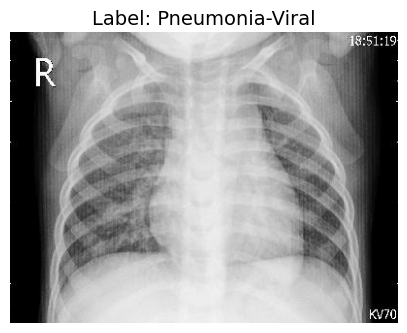

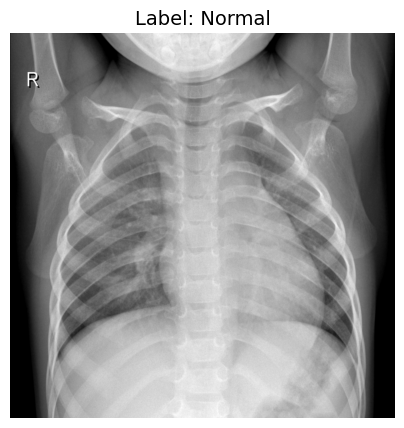

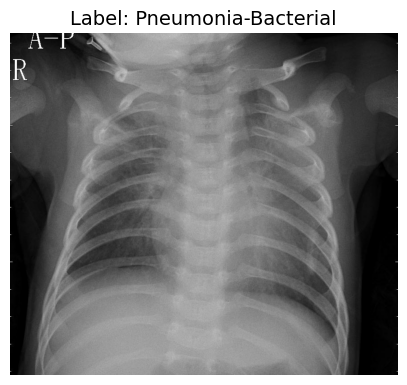

In [ ]:
display_random_images(test_dir, categories,5)

A method called display_random_images is defined in the code to randomly choose and present a certain number of images from different categories in a training directory. Each image is displayed in a plot with its category indicated.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(120, 120),
    batch_size= 64,
    color_mode='grayscale',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(120, 120),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(120, 120),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical')

We have divided into batch size 64 for each subdirectories(test, train and val).

In [ ]:

images, labels = next(train_generator)
print(labels)

print("Shape of image batch:", images.shape)
print("Shape of label batch:", labels.shape)

print("Type of images:", type(images))
print("Type of labels:", type(labels))

print("Image data type:", images.dtype)
print("Label data type:", labels.dtype)

print("Number of classes :", labels.shape[1])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
Shape of image batch: (64, 120, 120, 1)
Shape of label batch: (64, 3)
Type of images: <class 'numpy.ndarray'>
Type of labels: <class 'numpy.ndarray'>
Image data type: float32
Label data type: float32
Number of classes : 3


In [ ]:
print("Train folders:", os.listdir(train_dir))
print("Validation folders:", os.listdir(val_dir))
print("Test folders:", os.listdir(test_dir))

Train folders: ['Pneumonia-Viral', 'Pneumonia-Bacterial', 'Normal']
Validation folders: ['Pneumonia-Viral', 'Pneumonia-Bacterial', 'Normal']
Test folders: ['Pneumonia-Viral', 'Pneumonia-Bacterial', 'Normal']


In [ ]:
def plot_history(model):
  history_dict = model.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc_values = history_dict['acc']
  val_acc_values = history_dict['val_acc']
  epochs = range(1, len(history_dict['acc']) + 1)

  plt.plot(epochs, loss_values, 'y', label = 'Training loss')
  plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc_values, 'y', label = 'Training accuracy')
  plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  return plt.show()

The function plot_history gives us a model's training and validation loss and accuracy. It plots two graphs: one for loss and another for accuracy, each showing training and validation metrics.

In [ ]:

import seaborn as sns
def metrics(model, test_generator):
    true_labels = []
    predicted_labels = []
    predictions = []


    test_generator.reset()
    num_batches = len(test_generator)

    for i in range(num_batches):
        X_batch, y_true_batch = test_generator[i]

        y_pred_batch = model.predict(X_batch, verbose=0)

        true_labels.extend(np.argmax(y_true_batch, axis=1))
        predicted_labels.extend(np.argmax(y_pred_batch, axis=1))
        predictions.extend(y_pred_batch)


    predictions = np.array(predictions)

    # Accuracy score
    accuracy = accuracy_score(true_labels, predicted_labels)
    print("Accuracy  :- {:.2f}%".format(accuracy*100))

    # Classification report
    categories = list(test_generator.class_indices.keys())  # Class names from the generator
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=categories))

    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

    n_classes = len(categories)


    true_labels_bin = label_binarize(true_labels, classes=range(n_classes))

    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'green', 'red'])
    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {categories[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='lower right')
    plt.show()


Metrics evaluates a model using a test generator. It gives a detailed classification report of the confusion matrix, ROC, and AUC for the model.

In [ ]:
dense_model = tf.keras.models.Sequential([
    Flatten(input_shape = (120, 120, 1)),
    Dense(16, activation = 'relu'),
    Dense(32, activation = 'relu'),
    BatchNormalization(),
    Dense(64, activation = 'relu'),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dense(1024, activation = 'relu'),
    Dense(3, activation = 'softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
dense_model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['acc'])

dense_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         230,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 377,203 (1.44 MB)

 Trainable params: 376,883 (1.44 MB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
dense_history = dense_model.fit(train_generator,
                    epochs = 15,
                    verbose = 1,
                    validation_data = validation_generator,
                    callbacks =  EarlyStopping(monitor = "val_acc",min_delta = 0.0001,verbose=1,patience = 5,restore_best_weights = True,
                    baseline = None))

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - acc: 0.6915 - loss: 0.7027 - val_acc: 0.3826 - val_loss: 1.6031
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 86s 942ms/step - acc: 0.7891 - loss: 0.4961 - val_acc: 0.4520 - val_loss: 1.7129
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 71s 767ms/step - acc: 0.8034 - loss: 0.4610 - val_acc: 0.7184 - val_loss: 0.6783
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 81s 747ms/step - acc: 0.8302 - loss: 0.3998 - val_acc: 0.6187 - val_loss: 1.1808
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 71s 746ms/step - acc: 0.8321 - loss: 0.3839 - val_acc: 0.5076 - val_loss: 0.9123
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 82s 769ms/step - acc: 0.8387 - loss: 0.3825 - val_acc: 0.6149 - val_loss: 1.4554
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 69s 741ms/step - acc: 0.8416 - loss: 0.3578 - val_acc: 0.6490 - val_loss: 0.8590
Epoch 8/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 725ms/step - acc: 0.8497 - loss: 0.3588 - val_acc: 0.6035 - val_loss: 2.0169
Epoch 8: early stopping
Restoring model weights from the end 

In [ ]:
dense_model.evaluate(test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 736ms/step - acc: 0.7125 - loss: 0.6856


[0.689428985118866, 0.7109571695327759]

dense_model on a test dataset provided by test_generator gives evaluation reports an accuracy of 71.25% and a loss of 0.6856.

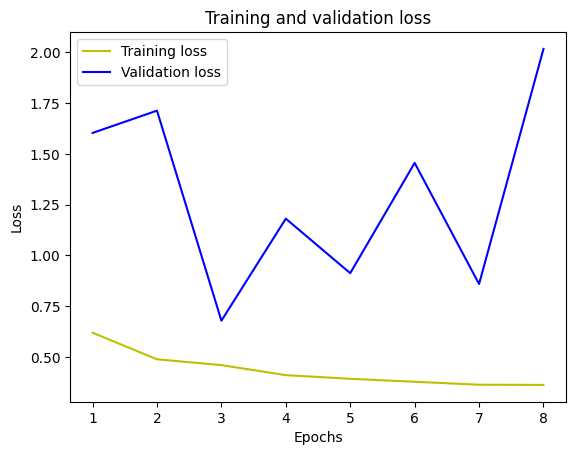

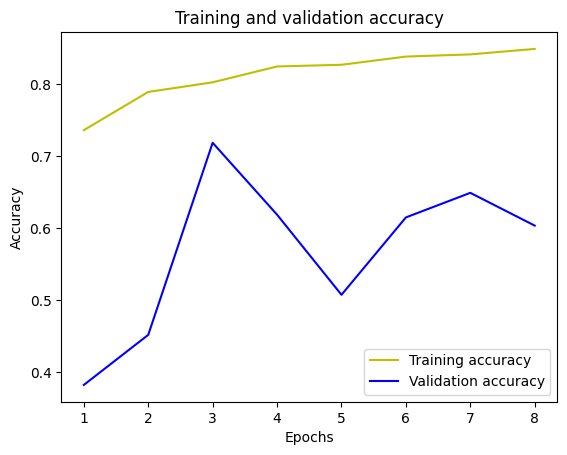

In [ ]:
plot_history(dense_history)


The first graph indicates a steady decrease in training loss, while the validation loss shows fluctuations, suggesting some variance in the model. The second graph indicates that training accuracy improves over time, and validation accuracy has significant fluctuations, which is overfitting.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


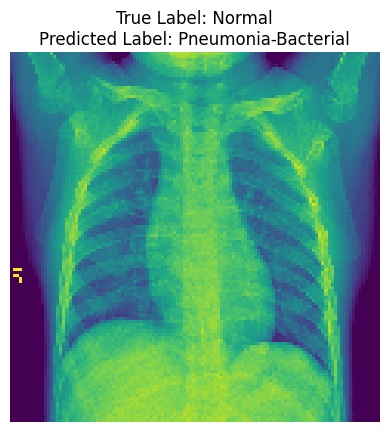

True Label: Normal
Predicted Label: Pneumonia-Bacterial


In [ ]:
test_dir = '/content/chestraydata1/Curated X-Ray Dataset/Curated X-Ray Dataset/test'

categories = os.listdir(test_dir)

true_label = random.choice(categories)
category_dir = os.path.join(test_dir, true_label)
image_files = os.listdir(category_dir)
image_file = random.choice(image_files)
img_path = os.path.join(category_dir, image_file)

img = image.load_img(img_path, target_size=(120, 120),color_mode = 'grayscale')
img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

predictions = dense_model.predict(img_array)

predicted_class_index = np.argmax(predictions, axis=1)[0]

predicted_label = categories[predicted_class_index]

plt.imshow(img)
plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
plt.axis('off')
plt.show()

print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")

To be able to compare the true label with the model's prediction and show the model's classification accuracy, the process involves reading and preprocessing the image, generating a prediction, and graphically showing the outcome.

Accuracy  :- 71.10%

Classification Report:
                     precision    recall  f1-score   support

             Normal       0.95      0.73      0.83       655
Pneumonia-Bacterial       0.70      0.88      0.78       601
    Pneumonia-Viral       0.36      0.36      0.36       332

           accuracy                           0.71      1588
          macro avg       0.67      0.66      0.66      1588
       weighted avg       0.73      0.71      0.71      1588



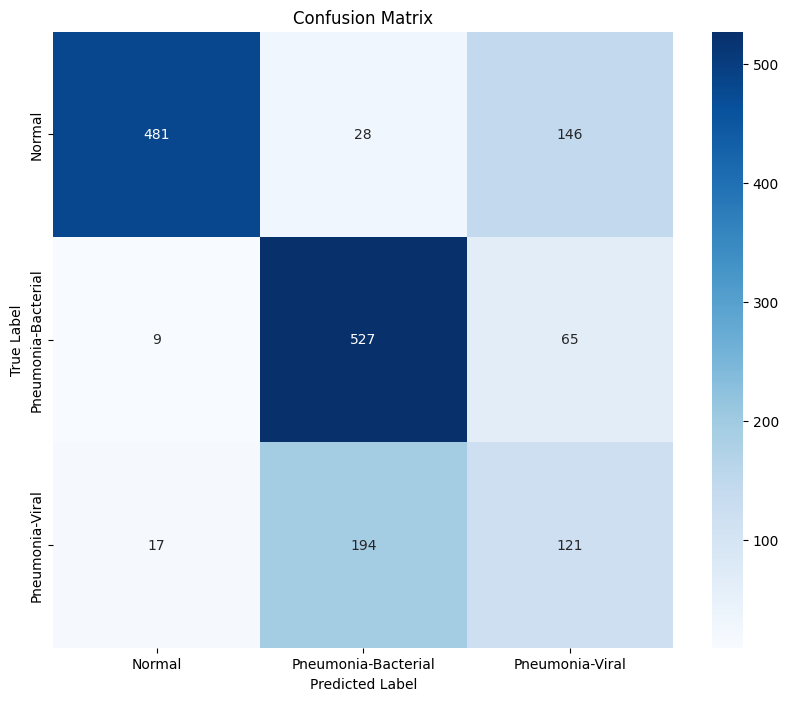

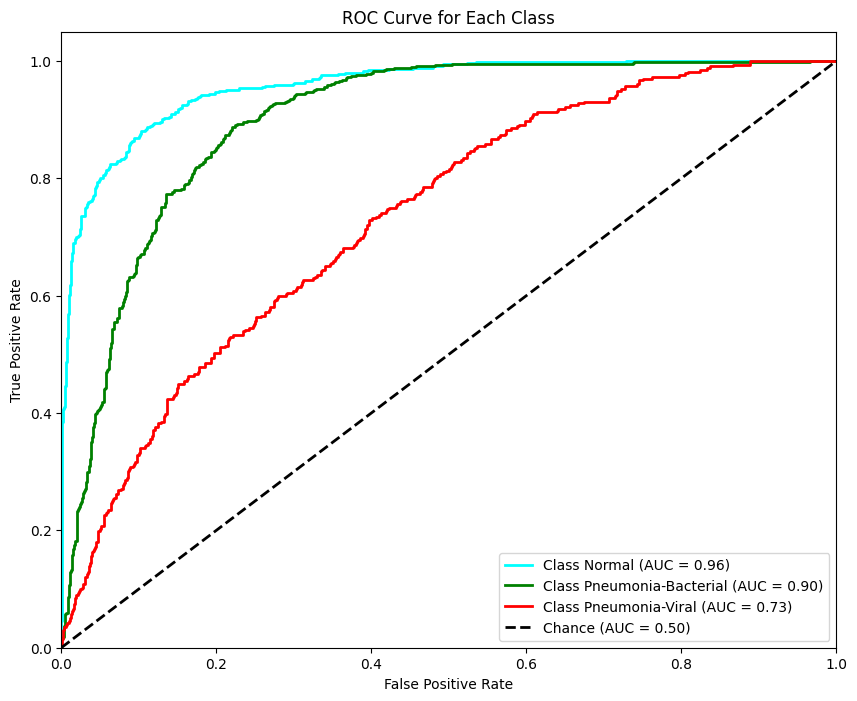

In [ ]:
metrics(dense_model,test_generator)

It shows the F1-score, precision, recall, and total accuracy of 71.10% for the three classes (Normal, Pneumonia-Bacterial, and Pneumonia-Viral). When it comes to F1-score and great precision in identifying 'Normal,' the model succeeds.

The model's ability to differentiate between each class and others is shown by the ROC curves for each class in the second image. The efficacy of the model is indicated by the AUC (Area Under the Curve) values, which are lower for the pneumonia-viral model and greater for the pneumonia-bacterial and normal models.

## Data Augmentation:

In [ ]:
train_datagen_Augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen= ImageDataGenerator(rescale=1./255)

train_generator_augmented = train_datagen_Augmented.flow_from_directory(
    train_dir,
    target_size=(120, 120),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical')

validation_generator_augmented = train_datagen_Augmented.flow_from_directory(
    val_dir,
    target_size=(120, 120),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical')

test_generator_augmented = test_datagen.flow_from_directory(
    test_dir,
    target_size=(120, 120),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical')

Found 5548 images belonging to 3 classes.
Found 792 images belonging to 3 classes.
Found 1588 images belonging to 3 classes.


To improve model durability, it initializes image data generators with augmentation for training and validation. It also initializes a standard generator for testing. While using data augmentation, we can create more images in all directories.

In [ ]:
from tensorflow.keras.models import Sequential
input_shape = (120, 120, 1)
def cnn_model(input_shpe):

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3)))
    model.add(MaxPool2D(2, 2))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=(3, 3)))
    model.add(Conv2D(64, kernel_size=(3, 3)))
    model.add(MaxPool2D(2, 2))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3)))
    model.add(Conv2D(128, kernel_size=(3, 3)))
    model.add(Dropout(0.2))
    model.add(MaxPool2D(2, 2))
    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(3, activation='softmax'))
    return model


In [ ]:
model_cnn = cnn_model(input_shape)
model_cnn.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 118, 118, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 116, 116, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 58, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 58, 58, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 54, 54, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 27, 27, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 23, 23, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │       3,965,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,295,971 (16.39 MB)

 Trainable params: 4,295,459 (16.39 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
model_cnn_history = model_cnn.fit(train_generator_augmented,
                    epochs = 15,
                    verbose = 1,
                    validation_data = validation_generator_augmented,
                    callbacks =  EarlyStopping(monitor = "val_accuracy",min_delta = 0.0001,verbose=1,patience = 5,restore_best_weights = True,
                    baseline = None))

Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 100s 908ms/step - accuracy: 0.6365 - loss: 0.9014 - val_accuracy: 0.4432 - val_loss: 1.0529
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 82s 844ms/step - accuracy: 0.7069 - loss: 0.6813 - val_accuracy: 0.3788 - val_loss: 1.2784
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 844ms/step - accuracy: 0.7118 - loss: 0.6558 - val_accuracy: 0.4886 - val_loss: 1.0119
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 94s 995ms/step - accuracy: 0.7232 - loss: 0.6296 - val_accuracy: 0.6338 - val_loss: 0.8203
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 91s 944ms/step - accuracy: 0.7357 - loss: 0.6286 - val_accuracy: 0.6705 - val_loss: 0.7748
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.7362 - loss: 0.6172 - val_accuracy: 0.6149 - val_loss: 0.8333
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.7478 - loss: 0.6037 - val_accuracy: 0.5164 - val_loss: 1.2674
Epoch 8/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7041 - loss: 0.6735 - val_accuracy: 0.

In [ ]:
model_cnn.evaluate(test_generator)

25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 685ms/step - accuracy: 0.7426 - loss: 0.7061


[0.7282047867774963, 0.7304785847663879]

Convolutional neural network (CNN) for image classification, then trains it using augmented data from a generator. After training, the model achieves an accuracy of 74.26% and a loss of 0.7061

In [ ]:
def plot_history_rep(model):
  history_dict = model.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc_values = history_dict['accuracy']
  val_acc_values = history_dict['val_accuracy']
  epochs = range(1, len(history_dict['accuracy']) + 1)

  plt.plot(epochs, loss_values, 'y', label = 'Training loss')
  plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc_values, 'y', label = 'Training accuracy')
  plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  return plt.show()

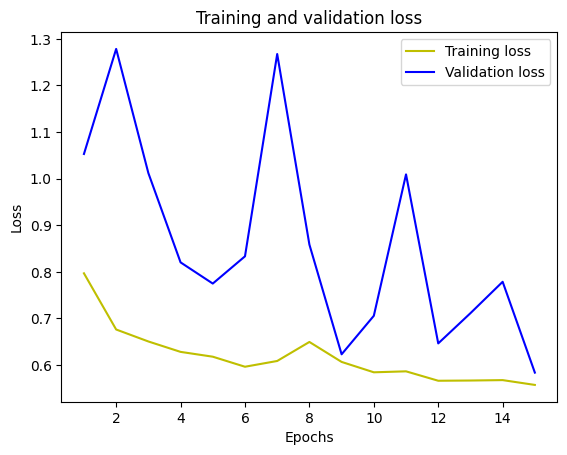

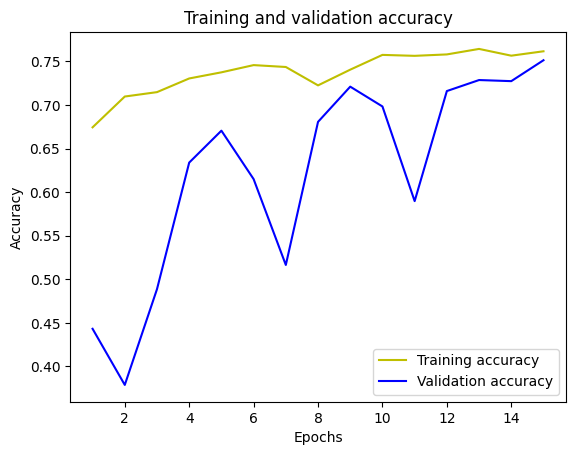

In [ ]:
plot_history_rep(model_cnn_history)

Accuracy  :- 73.05%

Classification Report:
                     precision    recall  f1-score   support

             Normal       0.83      0.97      0.89       655
Pneumonia-Bacterial       0.64      0.87      0.74       601
    Pneumonia-Viral       1.00      0.00      0.01       332

           accuracy                           0.73      1588
          macro avg       0.82      0.61      0.55      1588
       weighted avg       0.79      0.73      0.65      1588



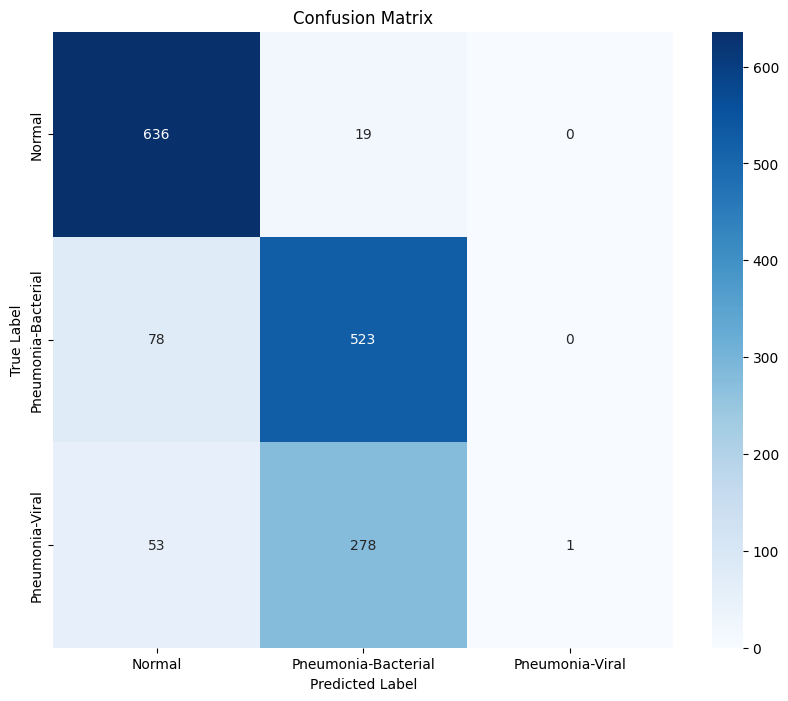

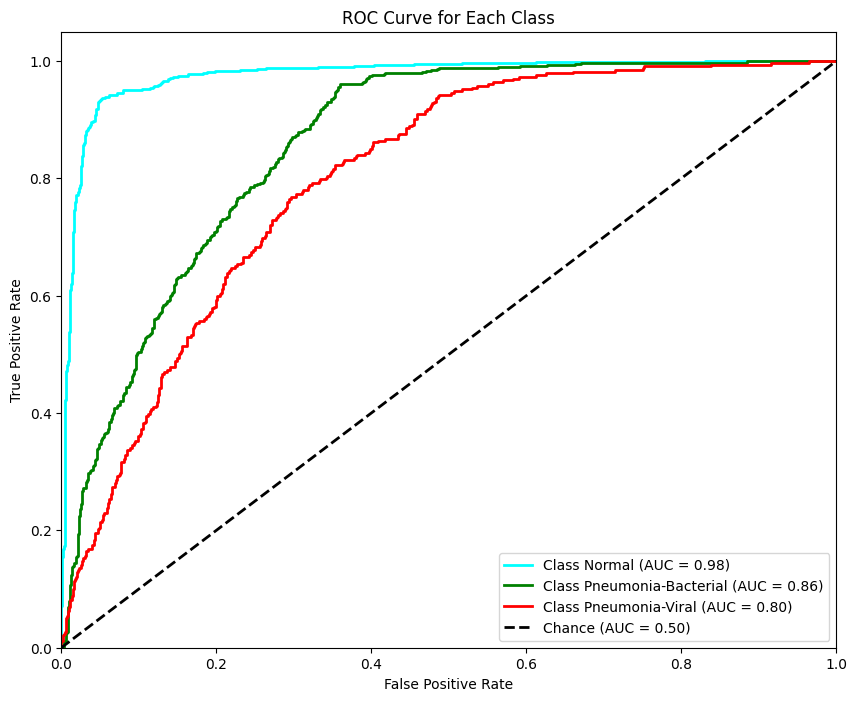

In [ ]:
metrics(model_cnn,test_generator)

The accuracy of the CNN was 73.05%. The accuracy curves show improvement with training, while the loss curves show significant variability in validation loss. Accuracy and other metrics are highlighted in the classification report for each class, and ROC curves show the model's discriminatory power together with the AUC values for each class, showing its effectiveness.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


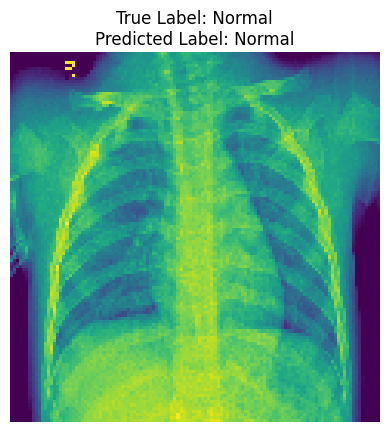

True Label: Normal
Predicted Label: Normal


In [ ]:

true_label = random.choice(categories)
category_dir = os.path.join(test_dir, true_label)
image_files = os.listdir(category_dir)
image_file = random.choice(image_files)
img_path = os.path.join(category_dir, image_file)

img = image.load_img(img_path, target_size=(120, 120),color_mode = 'grayscale')
img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

predictions = model_cnn.predict(img_array)

predicted_class_index = np.argmax(predictions, axis=1)[0]

predicted_label = categories[predicted_class_index]

plt.imshow(img)
plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
plt.axis('off')
plt.show()

print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")

Both the anticipated and true labels—both of which are "Normal"—are shown in the output. This suggests that the model has correctly determined that the chest X-ray is normal and free of anomalies or pneumonia-like symptoms.

In [ ]:
train_generator_augmented_resnet = train_datagen_Augmented.flow_from_directory(
    train_dir,
    target_size=(120, 120),
    batch_size=64,
    class_mode='categorical')

validation_generator_augmented_resnet = train_datagen_Augmented.flow_from_directory(
    val_dir,
    target_size=(120, 120),
    batch_size=64,
    class_mode='categorical')

test_generator_augmented_resnet = test_datagen.flow_from_directory(
    test_dir,
    target_size=(120, 120),
    batch_size=64,
    class_mode='categorical')

Found 5548 images belonging to 3 classes.
Found 792 images belonging to 3 classes.
Found 1588 images belonging to 3 classes.


resent works with only RGB images, so we are creating generator augment with input shape of (120, 120, 3) by removing grey sacle.

In [ ]:
from tensorflow.keras import backend
backend.clear_session()
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(120, 120, 3))


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False
for layer in base_model.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<BatchNormalization name=conv2_block1_preact_bn, built=True> False
<Activation name=conv2_block1_preact_relu, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<ZeroPadding2D name=conv2_block1_2_pad, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<Add name=conv2_block1_out, built=True> False
<BatchNormalization name=conv2_block2_preact_bn, built=True> False
<Activation name=co

It is pre-trained model. So, we don't have to retrain. We are preventing layers.

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model_resnet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_resnet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 120, 120, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 126, 126, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 60, 60, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 62, 62, 64)     │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 30, 30, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 30, 30, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 30, 30, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 30, 30, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 30, 30, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 30, 30, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 30, 30, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 30, 30, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 30, 30, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 30, 30, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 58,594,307 (223.52 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [ ]:
model_resnet_history = model_resnet.fit(train_generator_augmented_resnet,
                    epochs = 15,
                    verbose = 1,
                    validation_data = validation_generator_augmented_resnet,
                    callbacks =  EarlyStopping(monitor = "val_accuracy",min_delta = 0.0001,verbose=1,patience = 5,restore_best_weights = True,
                    baseline = None))

Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.7575 - loss: 0.5684 - val_accuracy: 0.7601 - val_loss: 0.5709
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.7774 - loss: 0.5286 - val_accuracy: 0.7778 - val_loss: 0.5628
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 91s 977ms/step - accuracy: 0.7848 - loss: 0.5281 - val_accuracy: 0.7790 - val_loss: 0.5225
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 140s 965ms/step - accuracy: 0.7774 - loss: 0.5142 - val_accuracy: 0.7740 - val_loss: 0.5506
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 89s 941ms/step - accuracy: 0.7775 - loss: 0.5217 - val_accuracy: 0.7551 - val_loss: 0.6078
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 959ms/step - accuracy: 0.7712 - loss: 0.5184 - val_accuracy: 0.7563 - val_loss: 0.5454
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 143s 953ms/step - accuracy: 0.7774 - loss: 0.5091 - val_accuracy: 0.7879 - val_loss: 0.5365
Epoch 8/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 90s 960ms/step - accuracy: 0.7811 - loss: 0.5263 - val_accur

In [ ]:
model_resnet.evaluate(test_generator_augmented_resnet)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 939ms/step - accuracy: 0.7578 - loss: 0.5505


[0.5225435495376587, 0.7695214152336121]

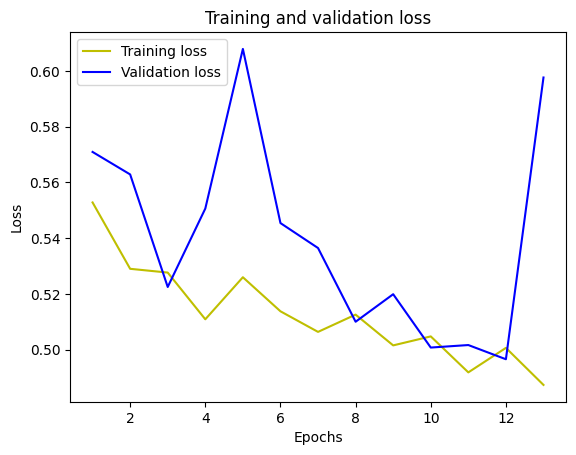

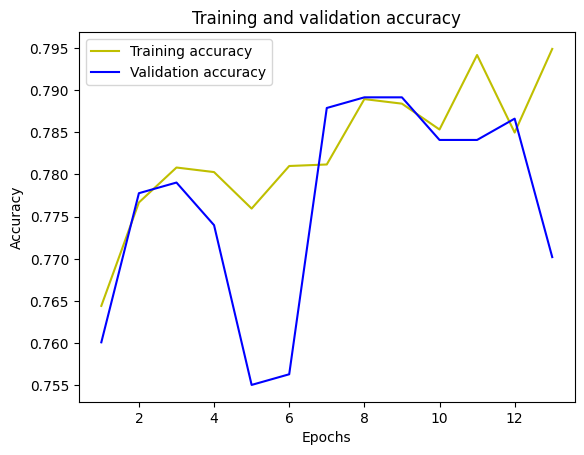

In [ ]:
plot_history_rep(model_resnet_history)

Accuracy  :- 76.95%

Classification Report:
                     precision    recall  f1-score   support

             Normal       0.87      0.96      0.91       655
Pneumonia-Bacterial       0.70      0.82      0.75       601
    Pneumonia-Viral       0.62      0.30      0.40       332

           accuracy                           0.77      1588
          macro avg       0.73      0.69      0.69      1588
       weighted avg       0.75      0.77      0.75      1588



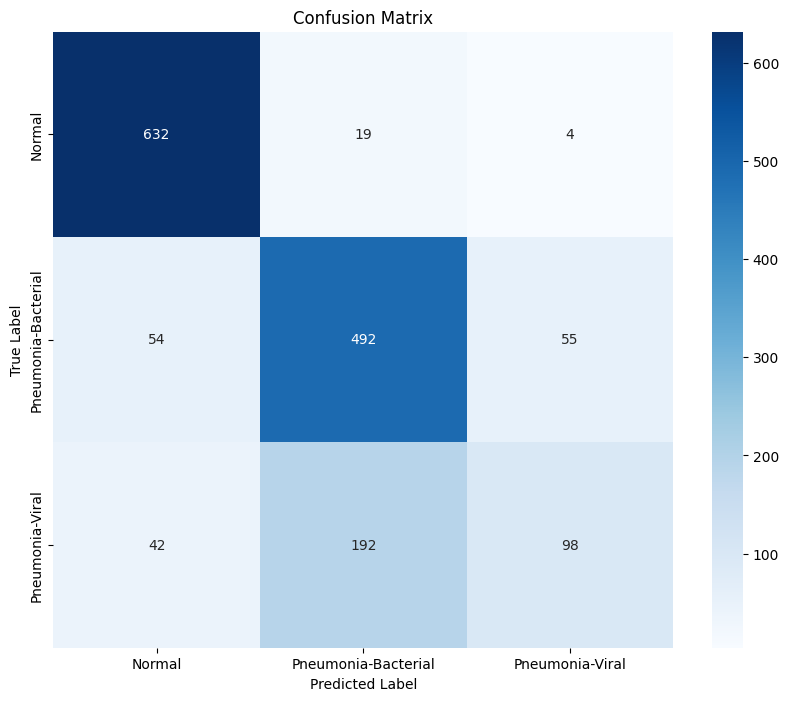

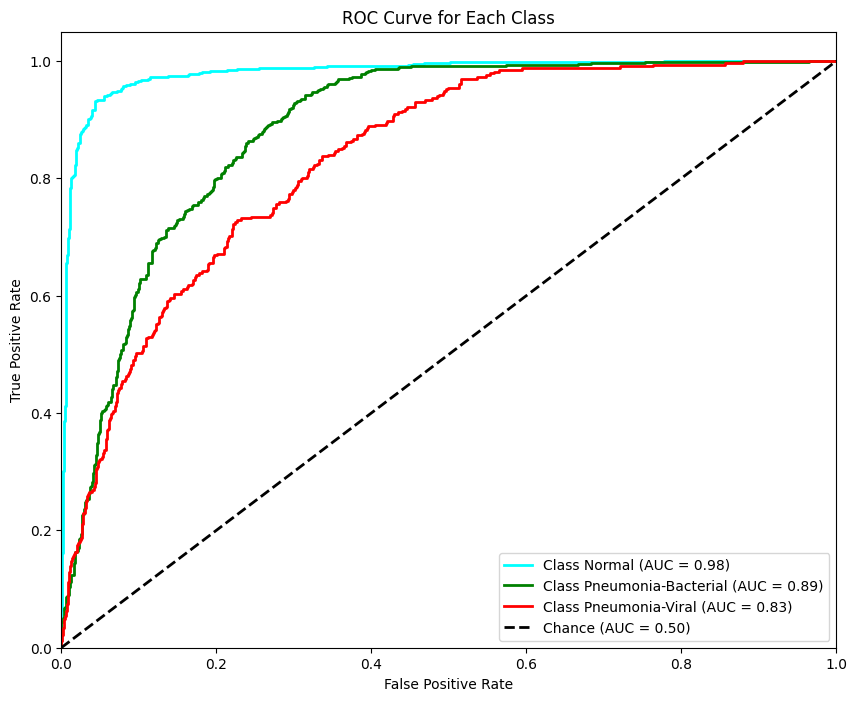

In [ ]:
metrics(model_resnet,test_generator_augmented_resnet)

The accuracy is 76%.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


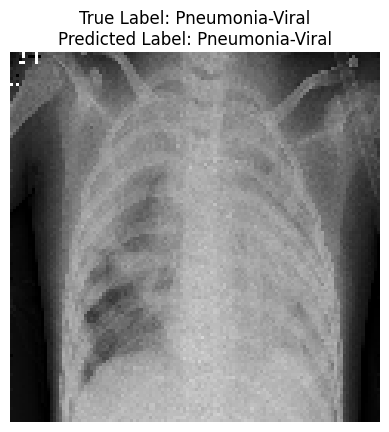

True Label: Pneumonia-Viral
Predicted Label: Pneumonia-Viral


In [ ]:
true_label = random.choice(categories)
category_dir = os.path.join(test_dir, true_label)
image_files = os.listdir(category_dir)
image_file = random.choice(image_files)
img_path = os.path.join(category_dir, image_file)

img = image.load_img(img_path, target_size=(120, 120))
img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

predictions = model_resnet.predict(img_array)

predicted_class_index = np.argmax(predictions, axis=1)[0]

predicted_label = categories[predicted_class_index]

plt.imshow(img)
plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
plt.axis('off')
plt.show()

print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")

This outcome indicates that the model correctly recognized the presence of viral pneumonia on the chest X-ray, which is consistent with the patient's actual condition as reported in the dataset label. The grayscale X-ray display helps in highlighting the information crucial to a medical diagnosis.

In [ ]:
model_resnet.save('model_resnet.keras')


#Summary of methods
- Binary Cross-Entropy is a popular loss function for binary classification applications.
- Optimizer: During training, the loss function was minimized using the Adam optimizer.
- Batch Size: For training, a suitable batch size (such as 32 or 64) was selected.
- Number of Epochs: In order to give the model time to converge, training was done over a predetermined number of epochs, most frequently 20–50.
- Metrics: The accuracy, precision, recall, F1-score, and AUC (Area Under the Curve) were used to assess performance.
- Data augmentation: To reduce overfitting and boost the variety of the training data, methods like as rotation, flipping, and random cropping were used.


#Summary of model

- The model selected for this project is a deep convolutional neural network architecture called ResNet (maybe ResNet-50), which has residual connections.
- Architecture: consists of convolutional layers that are connected by skip (residual) connections, which facilitate the propagation of gradients through the network and prevent them from disappearing.
- The remaining blocks preserve computational efficiency while enabling the model to learn from deeper levels.
- Output Layer: A sigmoid activation follows a fully linked layer to forecast whether a particular image is "Normal" or "Pneumonia."

#Analysis of results

The accuracy of the mode is 76.95%.

**Normal Class:**

- Precision: 0.87 – This means that when the model predicted a chest X-ray as "Normal," it was correct 87% of the time.
- Recall: 0.96 – Out of all the actual "Normal" cases, your model correctly identified 96% of them, which is excellent.
- F1-Score: 0.91 – This combines both precision and recall, and a score of 0.91 shows that your model is highly reliable when it comes to detecting normal chest X-rays.

**Pneumonia-Bacterial Class:**

- Precision: 0.70 – When the model predicted bacterial pneumonia, it was right 70% of the time. This means that 30% of the time, it’s confusing bacterial pneumonia with something else, which could be normal or viral pneumonia.
- Recall: 0.82 – Out of all the actual bacterial pneumonia cases, the model correctly identified 82%. This is pretty good, though it does miss 18% of these cases.
- F1-Score: 0.75 – This score shows that your model is decent at finding bacterial pneumonia, but there’s still room to improve.

**Pneumonia-Viral Class:**

- Precision: 0.62 – Here, the model predicted viral pneumonia correctly 62% of the time, but this means there are a lot of false positives—other conditions being misclassified as viral pneumonia.
- Recall: 0.30 – This is where the model struggles most. Only 30% of actual viral pneumonia cases are correctly identified. The model is missing a large portion of true viral pneumonia cases, meaning many of these are being misclassified as either bacterial pneumonia or normal.
- F1-Score: 0.40 – The low F1-score reflects the imbalance between precision and recall, confirming that the model isn’t performing well for this class.


**Confusion Matrix:**

The confusion matrix shows that the model is really good at identifying normal cases, with 632 out of 655 classified correctly. However, it's having a tough time with viral pneumonia—192 of those cases were wrongly predicted as bacterial pneumonia. This suggests the model finds it difficult to tell the difference between bacterial and viral pneumonia, leading to quite a few misclassifications.

**ROC curve:**

The ROC curve shows that the model is almost perfect at identifying normal cases (AUC = 0.98) and does a good job with bacterial pneumonia (AUC = 0.89). However, it's less accurate with viral pneumonia (AUC = 0.83), meaning the model has more trouble telling viral pneumonia apart from the other conditions.

##Reference

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

Stackoverflow